In [12]:
import scanpy as sc
import anndata as ad
import multigrate as mtg
from random import shuffle
from scipy import sparse
from matplotlib import pyplot as plt
import gdown

# Load the dataset

In [1]:
!wget "https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=expressions.h5ad" -O hao2020-expressions.h5ad

--2021-01-05 04:46:52--  https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=expressions.h5ad
Resolving localhost (localhost)... 127.0.0.1
Connecting to localhost (localhost)|127.0.0.1|:8085... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1949492332 (1.8G) [application/octet-stream]
Saving to: ‘hao2020-expressions.h5ad’

hao2020-expressions 100%[===================>]   1.82G  8.57MB/s    in 4m 16s  

2021-01-05 04:51:08 (7.26 MB/s) - ‘hao2020-expressions.h5ad’ saved [1949492332/1949492332]



In [5]:
scrna = sc.read('../data/hao-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 161764 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'cell_type'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'count'
    obsp: 'distances'

In [6]:
!wget "https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=protein.h5ad" -O hao2020-proteins.h5ad

--2021-01-05 04:51:19--  https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=protein.h5ad
Resolving localhost (localhost)... 127.0.0.1
Connecting to localhost (localhost)|127.0.0.1|:8085... connected.
Proxy request sent, awaiting response... 200 OK
Length: 904554908 (863M) [application/octet-stream]
Saving to: ‘hao2020-proteins.h5ad’

hao2020-proteins.h5 100%[===================>] 862.65M  5.81MB/s    in 2m 14s  

2021-01-05 04:53:34 (6.42 MB/s) - ‘hao2020-proteins.h5ad’ saved [904554908/904554908]



In [8]:
cite = sc.read('../data/hao-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 161764 × 224
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'cell_type'
    var: 'features'
    uns: 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'count'

# Paired setting

## Configure and train the model

In [14]:
model = mtg.models.MultiVAE(
    adatas=[[scrna], [cite]],
    names=[['RNA'], ['ADT']],
    pair_groups=[[0], [0]],
    condition=False,
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    layers=[['count'], [None]],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2, # don't have here as 1 dataset
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [15]:
model.train(
    n_iters=50000,
    batch_size=256,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=20000,
    validate_every=5000,
    verbose=1
)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


 |████████████████████| 100.0% iter=50000/50000, time=147.14(s), loss=2.5652, recon=2.5646, kl=63.0411, integ=0.0000, cycle=0.0000, val_loss=2.8320, val_recon=2.8314, val_kl=60.1624, val_integ=0.0000, val_cycle=0.0000

## Plot training history

In [16]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,5000,2.894525,2.894429,56.358703,0.0,0.0,2.858451,2.858280,68.430901,0,0
1,10000,2.857709,2.857369,84.313214,0.0,0.0,2.847649,2.847250,79.790268,0,0
2,15000,2.586306,2.585739,87.006519,0.0,0.0,2.863236,2.862498,98.423813,0,0
3,20000,2.641879,2.641144,81.873598,0.0,0.0,2.854599,2.853745,85.295662,0,0
4,25000,3.179292,3.178527,76.445502,0.0,0.0,2.838871,2.838188,68.334602,0,0
5,30000,3.107587,3.106872,71.441714,0.0,0.0,2.835807,2.835157,65.060326,0,0
6,35000,3.108971,3.108295,67.572713,0.0,0.0,2.832348,2.831731,61.703880,0,0
7,40000,2.562743,2.562089,65.434862,0.0,0.0,2.844807,2.844109,69.846947,0,0
8,45000,2.560200,2.559558,64.193427,0.0,0.0,2.835598,2.834948,65.050186,0,0
9,49999,2.565196,2.564565,63.041060,0.0,0.0,2.832010,2.831409,60.162437,0,0


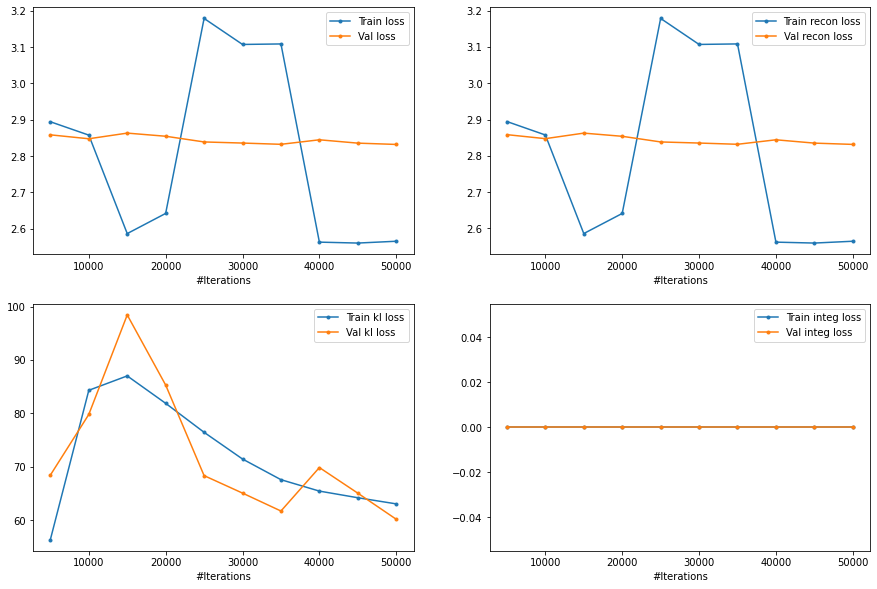

In [17]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Recover and visualize the latent space

In [19]:
z = model.predict(
    adatas=[[scrna], [cite]],
    names=[['RNA'], ['ADT']],
    pair_groups=[[0], [0]],
    batch_size=256,
)
z

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 161764 × 20
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [21]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/anastasia.litinetskaya/miniconda3/envs/multigrate/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  ada

In [26]:
z.obs_names = z.obs.barcode
z.obs

,modality,barcode,cell_type,batch
barcode,,,,
L1_AAACCCAAGAAACTCA,RNA-ADT,L1_AAACCCAAGAAACTCA,Mono,0
L1_AAACCCAAGACATACA,RNA-ADT,L1_AAACCCAAGACATACA,CD4 T,0
L1_AAACCCACAACTGGTT,RNA-ADT,L1_AAACCCACAACTGGTT,CD8 T,0
L1_AAACCCACACGTACTA,RNA-ADT,L1_AAACCCACACGTACTA,NK,0
L1_AAACCCACAGCATACT,RNA-ADT,L1_AAACCCACAGCATACT,CD8 T,0
...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,RNA-ADT,E2L8_TTTGTTGGTCGTGATT,CD8 T,631
E2L8_TTTGTTGGTGTGCCTG,RNA-ADT,E2L8_TTTGTTGGTGTGCCTG,Mono,631
E2L8_TTTGTTGGTTAGTTCG,RNA-ADT,E2L8_TTTGTTGGTTAGTTCG,B,631


In [27]:
z.obs_names == scrna.obs_names

array([ True,  True,  True, ...,  True,  True,  True])

In [29]:
z.obs = scrna.obs

In [30]:
z.obs

,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase,cell_type
L1_AAACCCAAGAAACTCA,7535.0,217,10823.0,2915,P2_7,L1,P2,7,Mono,CD14 Mono,CD14 Mono,G1,Mono
L1_AAACCCAAGACATACA,6013.0,209,5864.0,1617,P1_7,L1,P1,7,CD4 T,CD4 TCM,CD4 TCM_1,G1,CD4 T
L1_AAACCCACAACTGGTT,6620.0,213,5067.0,1381,P4_3,L1,P4,3,CD8 T,CD8 Naive,CD8 Naive,S,CD8 T
L1_AAACCCACACGTACTA,3567.0,202,4786.0,1890,P3_7,L1,P3,7,NK,NK,NK_2,G1,NK
L1_AAACCCACAGCATACT,6402.0,215,6505.0,1621,P4_7,L1,P4,7,CD8 T,CD8 Naive,CD8 Naive,G1,CD8 T
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2L8_TTTGTTGGTCGTGATT,4170.0,197,9346.0,2201,P5_7,E2L8,P5,7,CD8 T,CD8 Naive,CD8 Naive,S,CD8 T
E2L8_TTTGTTGGTGTGCCTG,6927.0,209,9318.0,2938,P5_3,E2L8,P5,3,Mono,CD14 Mono,CD14 Mono,G1,Mono
E2L8_TTTGTTGGTTAGTTCG,4222.0,206,11619.0,3224,P8_0,E2L8,P8,0,B,B intermediate,B intermediate kappa,S,B
E2L8_TTTGTTGGTTGGCTAT,6063.0,217,15436.0,3999,P5_3,E2L8,P5,3,Mono,CD16 Mono,CD16 Mono,G1,Mono


In [33]:
z.write('../data/integrated/multigrate/hao-multigrate.h5ad')

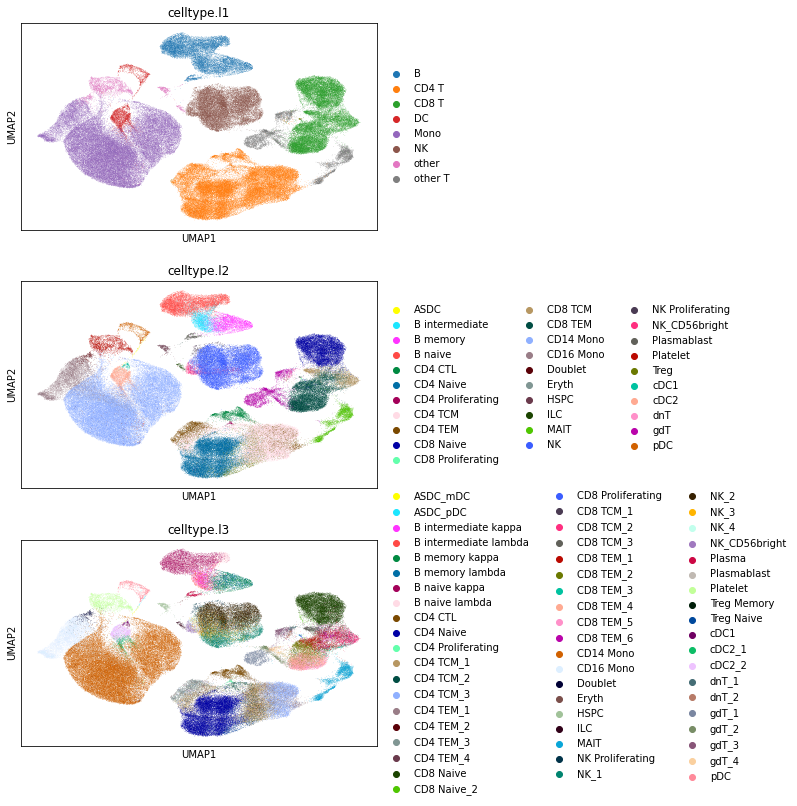

In [34]:
sc.pl.umap(z, color=['celltype.l1', 'celltype.l2', 'celltype.l3'], ncols=1)